In [ ]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.model_selection import train_test_split
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# chargement des données
steam = pd.read_csv('archive/steam.csv')
steam_description_data = pd.read_csv('archive/steam_description_data.csv')

# on ne devrait pas avoir besoin de celles-ci
'''
steam_media_data = pd.read_csv('steam_media_data.csv')
steam_requirements_data = pd.read_csv('steam_requirements_data.csv')
steam_support_info = pd.read_csv('steam_support_info.csv')
steamspy_tag_data = pd.read_csv('steamspy_tag_data.csv')
'''

# fonction pour afficher les informations d'un fichier
# si dimensions_type = True, les types des dimensions sont également affichés
def info(file, *dimensions_type):
    dataset_panda = pd.read_csv(file)
    print('*****'+file+'*****\n'+'Nombre de donnée: ', dataset_panda.shape[0],'\nNombre de dimension: ',
          dataset_panda.shape[1],'\n')
    if(dimensions_type):
        print('Types des dimensions:\n', dataset_panda.dtypes)

In [ ]:
info('archive/steam.csv', True)
steam

In [ ]:
info('archive/steam_description_data.csv', True)
steam_description_data

## Preprocessing

In [ ]:
# On récupère les valeurs de la colonne steam_appid du fichier steam.csv
steam_id = steam[steam.columns[0]].values
# On récupère toutes les valeurs de toutes les colonnes du fichier steam_description_data.csv
description = steam_description_data[steam_description_data.columns].values
# On récupère les titres des jeux
# titles = steam[steam.columns[1]].values

features = []
# Le fichier steam_description_data.csv contient plus de jeux que steam.csv, on ne récupère que ceux qu'ils ont en commun

# j = 0
for i in range(len(description)):
    if(description[i,0] in steam_id):
        # pour ajouter les titres des jeux
        #d = [titles[j]]
        #d = np.append(d, description[i, 1:])
        # j += 1
        
        # pour n'utiliser que les descriptions
        features.append(description[i, 1:])
        

# On récupère les données
X = np.array(features)
# On récupère les labels
label = steam.columns[9] # la colonne 9 correspond au genre du jeu
y = steam[label].values

In [ ]:
print('X: ',X.shape,'\ny: ',y.shape)

X:  (27075, 3) 
y:  (27075,)


In [ ]:
'''
X[0,0]: detailed_description
X[0,1]: about_the_game
X[0,2]: short_description
'''
# 1er jeu du fichier steam.csv
print('1er jeu du dataset:\n',X[0])
# son label
print('\nLabel: ',y[0])

1er jeu du dataset:
 ["Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role."
 "Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role."
 "Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role."]

Label:  Action


In [ ]:
# exemple d'un jeu dont la description est en chinois?
X[24881] 

array(['《魔塔2018》是一种策略类的RPG游戏。游戏需要动很多脑筋，任何一个轻率的选择都可能导致游戏的失败。<br />\r\n<br />\r\n魔塔制作精美，道具很多，而且有一定难度，对智商是一次艰巨的考验。<br />\r\n<br />\r\n所以如果你喜欢挑战，请一定不要错过!魔塔是一款十分经典的游戏,身为勇士的你必须闯过一层又一层的魔塔 最后到达塔顶 救回你那美丽的公主,魔塔里到处都充满着凶残的怪物，我们必须杀死他们。',
       '《魔塔2018》是一种策略类的RPG游戏。游戏需要动很多脑筋，任何一个轻率的选择都可能导致游戏的失败。<br />\r\n<br />\r\n魔塔制作精美，道具很多，而且有一定难度，对智商是一次艰巨的考验。<br />\r\n<br />\r\n所以如果你喜欢挑战，请一定不要错过!魔塔是一款十分经典的游戏,身为勇士的你必须闯过一层又一层的魔塔 最后到达塔顶 救回你那美丽的公主,魔塔里到处都充满着凶残的怪物，我们必须杀死他们。',
       '这是一款策略类的RPG游戏，通过你的判断与计算和怪物战斗，打败他们救出公主，赢得胜利。'], dtype=object)

### Fonctions

In [ ]:
def delete_no_english(X, y):
    steam_langage = steam[steam.columns[3]].values
    cpt = 0
    new_X = []
    new_y = []
    N = X.shape[0]
    for i in range(N):
        # si le jeu n'est pas en anglais
        if(steam_langage[i] == 1):
            new_X.append(X[i])
            new_y.append(y[i])
        else:
            cpt += 1
    print(cpt," jeux ont été enlevés\n")
    return np.array(new_X), np.array(new_y)

def html(s):
    split = s.split('<')
    # on le split à nouveau avec la balise fermante
    s_without_HTML = ""
    # supprimer html
    for i in range(len(split)):
        split[i] = split[i].split('>')
        if(i == 0):
            s_without_HTML += split[i][0]
        elif(len(split[i]) > 1 and split[i][1] != ""):
            if(split[i][1][0] == " "):
                s_without_HTML += split[i][1]
            else:
                s_without_HTML += " " + split[i][1]
    return s_without_HTML

def replace(s, new_values):
    N = len(new_values)
    for i in range(N):
        s = s.replace(new_values[i][0], new_values[i][1])
    return s

def brackets(s):
    brackets = np.array([['(', ')'], ['[', ']'], ['{', '}']])
    N = len(brackets)
    for b in range(N):
        split = s.split(brackets[b,0])
        s_without_brackets = ""
        for k in range(len(split)):
            split[k] = split[k].split(brackets[b,1])
            if(k == 0):
                s_without_brackets += split[k][0]
            elif(len(split[k]) > 1 and split[k][1] != ''):
                if(split[k][1][0] == ' '):
                    s_without_brackets += split[k][1]
                else:
                    s_without_brackets += " " + split[k][1]
        s = s_without_brackets
    return s

def character(s, characters):
    # les éléments de characters seront remplacés par un espace " "
    translation = str.maketrans({i:" " for i in characters})
    # on sépare les mots et on les met dans la liste X_split
    split = s.split(' ')
    s_without_link = ""
    for i in split:
        # on vérifie que chaque mot ne contient pas 'http' ou 'www'
        if(not 'http' in i and not 'www' in i):
            s_without_link += i + " "
        # on supprime les caractères à supprimer
    return s_without_link.translate(translation)

def backslashes(s):
    l = ['\x91','\x92','\x94','\x93','\x97','\x96','\x80','\x99','\x98','\xad','\x7f','\u200b','\u200f','\ufeff','/','\n',
        '\t','\r']
    for i in l:
        s = s.replace(i, " ")
    return s

def numbers_lowerCase(s):
    s_without_numbers = ""
    N = len(s)
    for i in range(N):
        if(s[i].isdigit()):
            s_without_numbers += " "
        else:
            s_without_numbers += s[i]
    return s_without_numbers.lower()

def stopword(s, stopwords):
    modif = False
    split = s.split(" ")
    s_without_stopwords = ""
    for i in split:
        if(i not in stopwords):
            s_without_stopwords += i + " "
    split = s_without_stopwords.split(" ")
    s_without_one_letter_words = ""
    N = len(split)
    for i in range(N):
        if(len(split[i]) > 1 and split[i] != " "):
            modif = True
            if(i == N - 1): # dernier élement donc on ne met pas d'espace
                s_without_one_letter_words += split[i]
            else:
                s_without_one_letter_words += split[i] + " "
    N = len(s_without_one_letter_words)
    # on vérifie que le dernier caractère n'est pas un espace
    if(modif and s_without_one_letter_words[N-1] == " "):
        s_without_one_letter_words = s_without_one_letter_words[:N-1]
    return s_without_one_letter_words

def clear_string(s, replacement, characters, stopwords):
    return stopword(numbers_lowerCase(backslashes(character(brackets(replace(html(s), replacement)), characters))), stopwords)

def clear_all_data(X, replacement, characters, stopwords):
    N = X.shape[0]
    D = X.shape[1]
    for i in range(N):
        for j in range(D):
            X[i,j] = clear_string(X[i,j], replacement, characters, stopwords)
        
def delete_no_ascii(X, y):
    new_X = []
    new_y = []
    cpt=0
    for i in range(len(X)):
        # indique si il y a des caractères non ascii
        no_ascii = True
        for e in X[i]:
            # si le caractères n'est pas ascii
            if(re.sub('[ -~]', '', e) != ""):
                no_ascii = False
        if(no_ascii):
            new_X.append(X[i])
            new_y.append(y[i])
        else:
            cpt += 1
    print(cpt," jeux ont été enlevés\n")
    return np.array(new_X), np.array(new_y)

def remove_genres(X, y, tokenized=False):
    N = X.shape[0]
    D = X.shape[1]
    genres = get_labels(y)
    for i in range(N):
        for j in range(D):
            if(tokenized):
                for k in X[i,j]:
                    if(k in genres):
                        X[i,j].remove(k)
            else:
                X_split = X[i,j].split(" ")
                for k in X_split:
                    if(k in genres):
                        X[i,j] = X[i,j].replace(k, "")
                        
def lemmatize(X, tokenize=False):
    N = X.shape[0]
    D = X.shape[1]
    new_X = np.empty((N, D), object)
    lemmatizer = WordNetLemmatizer()
    for i in range(N):
        for j in range(D):
            X_split = X[i,j].split(" ")  
            X_lemmatized = ""
            for k in range(len(X_split)):
                if(k == len(X_split) - 1):
                    X_lemmatized += lemmatizer.lemmatize(X_split[k], wordnet.VERB)
                else:
                    X_lemmatized += lemmatizer.lemmatize(X_split[k], wordnet.VERB) + " "
            if(tokenize):
                new_X[i,j] = X_lemmatized.split(" ")
            else:
                new_X[i,j] = X_lemmatized
    return new_X

# renvoi la liste des labels contenus dans y
def get_labels(y):
    labels = []
    N = y.shape[0]
    for i in range(N):
        y_split = y[i].split(" ")
        for j in y_split:
            if(j not in labels and j != " "):
                labels.append(j)
    return np.array(labels)

def rename_labels(y):
    N = y.shape[0]
    characters = ["&", ";"]
    translation = str.maketrans({i:" " for i in characters})
    for i in range(N):
        y[i] = y[i].translate(translation).lower()
        y[i] = y[i].replace("free to play", "free")
        y[i] = y[i].replace("animation   modeling", "animation")
        y[i] = y[i].replace("video production", "video")
        y[i] = y[i].replace("massively multiplayer", "multiplayer")
        y[i] = y[i].replace("early access", "early")
        y[i] = y[i].replace("design   illustration", "design")
        y[i] = y[i].replace("web publishing", "web")
        y[i] = y[i].replace("software training", "software")
        y[i] = y[i].replace("sexual content", "sexual")
        y[i] = y[i].replace("audio production", "audio")
        y[i] = y[i].replace("game development", "development")
        y[i] = y[i].replace("photo editing", "photo")
        #y[i] = y[i].replace("rpg", "role")
        
def keep_first_label_only(y):
    N = y.shape[0]
    new_y = []
    for i in range(N):
        y_split = y[i].split(" ")
        new_y.append(y_split[0])
    return np.array(new_y)

def prepro(X, y, replacement, character, stopwords):
    print("Preprocessing: environ 3m\n\nSuppression des jeux non anglais: ")
    X, y = delete_no_english(X, y)
    print("✔\n")
    print("Nettoyage du texte: ")
    clear_all_data(X, replacement, character, stopwords)
    print("✔\n")
    print("Suppression des caractères non ASCII restants: ")
    X, y = delete_no_ascii(X, y)
    print("✔\n")
    print("Renommage des labels: ")
    rename_labels(y)
    print("✔\n")
    return X, y

# sélectionne aléatoirement nb données dans le dataset
def select_data(X, y, nb):
    new_X = np.empty((nb, X.shape[1]), object)
    new_y = np.array([])
    N = X.shape[0]
    index = np.arange(N)
    for i in range(nb):
        r = random.randint(0, len(index)-1)
        new_X[i] = X[r]
        new_y = np.append(new_y, y[r])
        index = np.delete(index, r)
    return new_X, new_y

In [ ]:
replacement = np.array([["ê","e"],["é","e"],["è","e"],["ë","e"],["à","a"],["ä","a"],["ä","a"],["å","a"],["ł","l"],
                        ["ü","u"],["û","u"],["ö","o"],["ô","o"],["Ö","o"],["ò","o"],["í","i"],["ï","i"],["î","i"],["Ã","a"],
                        ["Ä","a"],["ž","z"],["ì","i"],["Ñ","n"],["ñ","n"],["á","a"],["ø","o"],["Á","a"],["á","a"],
                        ["Ü","u"],["ō","o"],["ú","u"],["ã","a"],["É","e"],["×","x"],["Ó","o"],["С","c"],["、",","],
                        ["ɑ","a"],["ñ","n"],["ũ","u"],["ó","o"],["â","a"],["Û","u"],["ū","u"],["õ","o"],["，",","],
                        ["ń","n"],["х","x"],["А","a"],["с","c"],["Ś","s"],["Т","t"],["a","a"]])

character_to_delete = np.array(['•','€','™','*','-','–','¢','˜','«','»','®','+','µ','·','¹','¬','º','½','±','©','§','ª','ƒ',
                              '¿','Ð','¸','¼','Ø','¨','æ','‡','“','”','ç','¥','œ','´','#','—','‘','…', '²', '●', '³', '・',
                                '∞','√','∼','✢','※','◾','■','★','➠','―','„','✓','▶','◆','ລ','▪','♪','♞','♥','Ω','α',
                                'Λ','♫','「','」','：','◕','_','つ','༽','༼','⚠','✔','』','『','►','☆','℗','✗','✪','†','《',
                                '》','一','。','～','‐','″','↑','@','◉','♂','♀','＊','【','】','＊','＜','＞','→','↓','←',
                                '①','②','③','▽','△','○','Ⅶ','□','（','）','%','Ⅱ','~','°','&',',', '!', '?', ':', '.', ';',
                                '"',"'",'′','’','＋','=','|','~','^', '@','$'])

stopwords = np.loadtxt("stopwords.txt",str)

In [ ]:
# remove_genre indique s'il faut supprimer les occurences des labels dans les descriptions
X, y = prepro(X, y, replacement, character_to_delete, stopwords)

Preprocessing: environ 3m

Suppression des jeux non anglais: 
511  jeux ont été enlevés

✔

Nettoyage du texte: 
✔

Suppression des caractères non ASCII restants: 
659  jeux ont été enlevés

✔

Renommage des labels: 
✔



In [ ]:
print('X: ',X.shape,'\ny: ',y.shape)

X:  (25905, 3) 
y:  (25905,)


In [ ]:
# premier jeu du dataset:
X[0], y[0]

(array(['world online action game engage incredibly realistic brand terrorist warfare wildly popular team based game ally teammates complete strategic missions enemy sites rescue hostages role affects team success team success affects role',
        'world online action game engage incredibly realistic brand terrorist warfare wildly popular team based game ally teammates complete strategic missions enemy sites rescue hostages role affects team success team success affects role',
        'world online action game engage incredibly realistic brand terrorist warfare wildly popular team based game ally teammates complete strategic missions enemy sites rescue hostages role affects team success team success affects role'],
       dtype=object), 'action')

Pour le préprocessing nous effectuons les tâches suivantes:
- on enlève les jeux qui ne sont pas étiquetés 'english'
- certains caractères non reconnus sont remplacés par un caractère ASCII équivalent
- certains caractères non ASCII et les liens sont supprimés
- on supprime le code HTML, les différents types de parenthèses et leur contenu, les backslashes et les slashes
- on supprime tous les nombres
- les majuscules sont transformées en minuscules
- on supprime les jeux dont les descriptions contiennent encore des caractères non ASCII
- on supprime les stopwords, ce sont des mots qui n'ont pas d'intérêt ou de réelle signification
- on supprime les caractères isolés (pour le mot '3d', le '3' a été supprimé donc on supprime aussi le 'd')
- on renomme certains labels ('free to play' devient 'free', etc..) et on ne garde que le premier de chaque jeu
- on effectue la lemmatisation

On ne supprime pas tous les jeux dont une des description contient des caractères non ASCII car certains jeux n'ont que quelques caractères de ce type dans leurs descriptions, il suffit juste de les remplacer ou de les enlever mais ce n'est pas nécessaire de retirer le jeu du dataset. Une fois qu'on a fait ce tri on retire tous les jeux qui contiennent encore des caractères non ASCII (il n'en reste plus beaucoup), il reste par exemple les descriptions en alphabet russe, caractères chinois... On "sauve" environ 10000 jeux dans la dataset comme ça.

La lemmatisation est un traitement lexical sur le texte, par exemple les mots suivants seront transformés comme ça (ce qui rend les choses plus simple pour le modèle):
- les mots au pluriel sont mis au singulier: feet -> foot, cars -> car
- les verbes sont mis à l'infinitif: working -> work
- etc

Pour la lemmatisation on peut en plus transformer les descriptions en listes de mots ou bien les laisser en string (on choisit avec le paramètre tokenize). La phrase 'fate hero hands stranger planet occasion return finally stays decides local people' devient après lemmatisation:
- 'fate hero hand stranger planet occasion return finally stay decide local people' : sans tokenize  

- ['fate', 'hero', 'hand', 'stranger', 'planet', 'occasion', 'return', 'finally', 'stay', 'decide', 'local', 'people'] : avec tokenize

Certains jeux ont plusieurs labels, on ne sait pas si c'est possible de prédire plusieurs mots avec le modèle donc nous avons choisis de ne prendre que le 1er genre du jeu (les genres ne sont pas mis dans l'ordre alphabétique pour les jeux qui en ont plusieurs on peut donc supposer que le genre qui apparaît en premier est le "principal" du jeu). On utilise pour ça la fonction keep_first_label_only(y)

In [ ]:
# Lemmatisation

# Pour que les descriptions soient des listes de mots
X_tokenized = lemmatize(X, tokenize=True)

# Pour laisser les descriptions en chaînes de caractères
X_not_tokenized = lemmatize(X)

In [ ]:
# Voilà ce qu'on obtient sur le 1er jeu avec X_tokenized
print('X_tokenized[0]:\n', X_tokenized[0])

X_tokenized[0]:
 [list(['world', 'online', 'game', 'engage', 'incredibly', 'realistic', 'brand', 'terrorist', 'warfare', 'wildly', 'popular', 'team', 'base', 'game', 'ally', 'teammates', 'complete', 'strategic', 'missions', 'enemy', 'sit', 'rescue', 'hostages', 'role', 'affect', 'team', 'success', 'team', 'success', 'affect', 'role'])
 list(['world', 'online', 'game', 'engage', 'incredibly', 'realistic', 'brand', 'terrorist', 'warfare', 'wildly', 'popular', 'team', 'base', 'game', 'ally', 'teammates', 'complete', 'strategic', 'missions', 'enemy', 'sit', 'rescue', 'hostages', 'role', 'affect', 'team', 'success', 'team', 'success', 'affect', 'role'])
 list(['world', 'online', 'game', 'engage', 'incredibly', 'realistic', 'brand', 'terrorist', 'warfare', 'wildly', 'popular', 'team', 'base', 'game', 'ally', 'teammates', 'complete', 'strategic', 'missions', 'enemy', 'sit', 'rescue', 'hostages', 'role', 'affect', 'team', 'success', 'team', 'success', 'affect', 'role'])]


In [ ]:
# Voilà ce qu'on obtient sur le 1er jeu avec X_not_tokenized
print('\nX_not_tokenized[0]:\n', X_not_tokenized[0])


X_not_tokenized[0]:
 ['world online action game engage incredibly realistic brand terrorist warfare wildly popular team base game ally teammates complete strategic missions enemy sit rescue hostages role affect team success team success affect role'
 'world online action game engage incredibly realistic brand terrorist warfare wildly popular team base game ally teammates complete strategic missions enemy sit rescue hostages role affect team success team success affect role'
 'world online action game engage incredibly realistic brand terrorist warfare wildly popular team base game ally teammates complete strategic missions enemy sit rescue hostages role affect team success team success affect role']


In [ ]:
# Labels
print('Tous les labels: \n', get_labels(y))
print('Il y a ', len(get_labels(y)), ' labels uniques\n')

# Pour ne garder que le premier genre d'un jeu
y_first = keep_first_label_only(y)
print("Tous les labels: \n", get_labels(y_first))
print('Il y a ', len(get_labels(y_first)), ' labels uniques si on ne prends que les 1er de chaque jeu\n')

Tous les labels: 
 ['action' 'free' 'strategy' 'adventure' 'indie' 'rpg' 'animation' 'video'
 'casual' 'simulation' 'racing' 'violent' 'multiplayer' 'nudity' 'sports'
 'early' 'gore' 'utilities' 'design' 'web' 'education' 'software' 'sexual'
 'audio' 'development' 'photo' 'accounting' 'documentary' 'tutorial']
Il y a  29  labels uniques

Tous les labels: 
 ['action' 'indie' 'strategy' 'rpg' 'animation' 'casual' 'simulation'
 'racing' 'adventure' 'violent' 'nudity' 'free' 'sports' 'gore'
 'multiplayer' 'utilities' 'design' 'education' 'web' 'sexual' 'audio'
 'photo' 'early' 'accounting' 'video' 'software']
Il y a  26  labels uniques si on ne prends que les 1er de chaque jeu



## Debut visualisation

In [ ]:
def get_labels_list(y):
    labels = []
    N = y.shape[0]
    for i in range(N):
        y_split = y[i].split(" ")
        for j in y_split:
            if(j != " "):
                labels.append(j)
    return np.array(labels)

print(y)
print(get_labels_list(y))

['action' 'action' 'action' ... 'action casual indie'
 'adventure casual indie' 'adventure casual indie']
['action' 'action' 'action' ... 'adventure' 'casual' 'indie']


In [ ]:
#fonction qui prend en param:
#liste y du dataset (taille=76k)
#et liste des 26 genres qui existent sans duplication (taille=26)
def genre_count(y, genres):
    list_genre_count = []
    for genre in genres:
        count=0
        for genre2 in y:
            if genre==genre2:
                count+=1
        list_genre_count.append(count)
    return list_genre_count

genreLabels = get_labels(y_first)
list_genre_count=genre_count(get_labels_list(y), genreLabels)
print(list_genre_count)

[11542, 18611, 4984, 3944, 76, 9799, 4949, 988, 9522, 806, 243, 1604, 1284, 511, 685, 140, 85, 50, 27, 223, 27, 11, 2819, 5, 35, 30]


Text(0.5, 1.0, 'Nombre de jeux par genre')

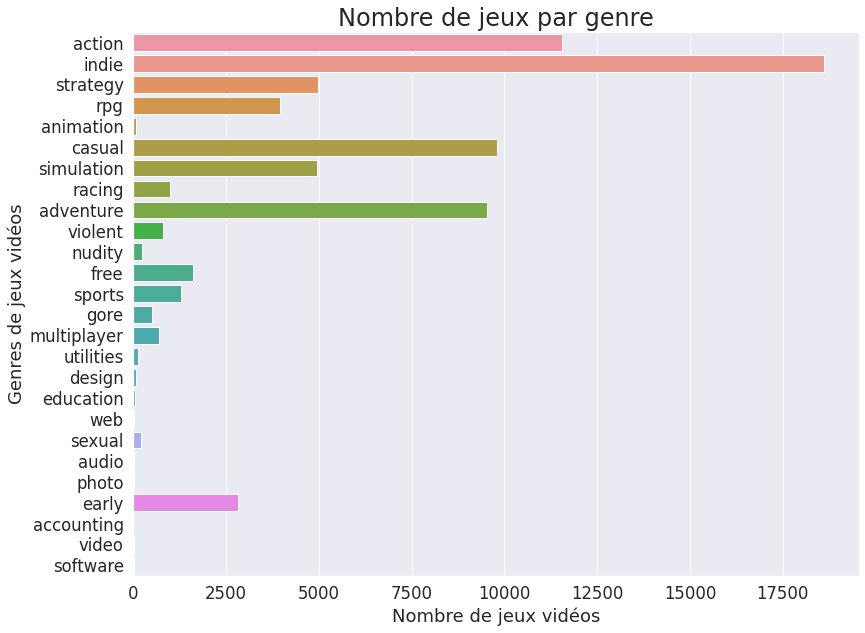

In [ ]:
plt.figure(figsize=(13, 10))
# Bar chart
sns.set(font_scale=1.5) #taille du texte
sns.barplot(x=list_genre_count, y=genreLabels)
plt.xlabel("Nombre de jeux vidéos")
plt.ylabel("Genres de jeux vidéos")
sns.set(font_scale=2)
plt.title("Nombre de jeux par genre")

In [ ]:
def count_genre_in_description(X, y, tokenized=False):
    N = X.shape[0]
    D = X.shape[1]
    genres = y
    count=0
    for i in range(N):
        for j in range(D):
            if(tokenized):
                for k in X[i,j]:
                    if(k in genres[i]):
                        count+=1
                        break #on compte seulement 1 fois si un jeu a son genre en description
                              #peu importe si la description contient le genre une ou plusieurs fois
            else:
                X_split = X[i,j].split(" ")
                for k in X_split:
                    if(k in genres[i]):
                        count+=1
                        break #on compte seulement 1 fois si un jeu a son genre en description
                              #peu importe si la description contient le genre une ou plusieurs fois
    return count

In [ ]:
# tokkenized est à True car on utilise X_tokkenized
nb_jeu_avec_genre_en_description=count_genre_in_description(X_tokenized, y_first, tokenized=True)
nb_jeu_total=len(y_first)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


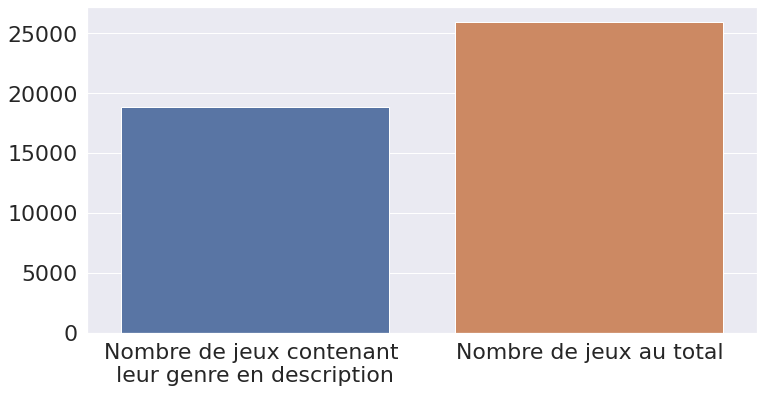

In [ ]:
plt.figure(figsize=(12, 6))

x_bar = ['Nombre de jeux contenant \nleur genre en description', 'Nombre de jeux au total']
y_bar = [nb_jeu_avec_genre_en_description, nb_jeu_total]

sns.barplot(x_bar, y_bar)

## Fin visualisation

### Ensembles d'entraînement et de test

In [ ]:
# on choisit d'utiliser 10000 jeux du dataset (sélectionnés aléatoirement) avec X_tokenized et en ne prenant que le 1er label
X1, y1 = select_data(X_tokenized, y_first, 10000)

# tokkenized est à True car on utilise X_tokkenized
remove_genres(X1, y1, tokenized=True)

In [ ]:
seed = 7
# pourcentage du dataset utilisé pour l'ensemble de test
test_ratio = 0.3

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=test_ratio, train_size=1-test_ratio,
                                                    random_state=seed)

print('X_train: ',X_train.shape,'\ny_train: ',y_train.shape,'\n\nX_test: ',X_test.shape,'\ny_test: ',y_test.shape)
print("\nL'ensemble d'entraînement possède des jeux de ",len(get_labels(y_train)), " classes différentes")

X_train:  (7000, 3) 
y_train:  (7000,) 

X_test:  (3000, 3) 
y_test:  (3000,)

L'ensemble d'entraînement possède des jeux de  25  classes différentes


In [ ]:
X_train, y_train

(array([[list(['archotek', 'project', 'focus', 'experience', 'give', 'chance', 'people', 'dedicate', 'servers', 'dinosaur', 'species', 'explore', 'exotic', 'locations', 'map', 'choice', 'role', 'friends', 'create', 'stories', 'stick', 'basics', 'pvp', 'involve', 'deadly', 'fight', 'players', 'version', 'include', 'access', 'public', 'servers', 'map', 'sanctuary', 'vulture', 'plain', 'green', 'valley', 'aran', 'desert', 'playable', 'character', 'camarasaurus', 'deinonychus', 'parasaurolophus', 'psittacosaurus', 'game', 'mode', 'dinosaur', 'full', 'version', 'include', 'access', 'public', 'servers', 'realism', 'server', 'map', 'sanctuary', 'massive', 'map', 'include', 'tropical', 'islands', 'green', 'valley', 'small', 'map', 'players', 'explore', 'meet', 'people', 'powerful', 'build', 'aran', 'desert', 'medium', 'size', 'map', 'represent', 'large', 'desert', 'surround', 'canyons', 'oases', 'vulture', 'plain', 'medium', 'size', 'map', 'large', 'plain', 'cave', 'system', 'redwood', 'forest

##Preprocessing supplémentaire pour utiliser la méthode bag of words

In [ ]:
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

In [ ]:
X_lines=[sub[0] for sub in X_not_tokenized] #on recupere la liste de description unique
X_lines[:5] #on affiche les 5 premiers descriptions pour montrer

['world online action game engage incredibly realistic brand terrorist warfare wildly popular team base game ally teammates complete strategic missions enemy sit rescue hostages role affect team success team success affect role',
 'popular online action game time team fortress classic feature character class medic spy demolition man enlist unique style online team warfare character class possess unique weapons items abilities team compete online variety game modes',
 'enlist intense brand axis ally teamplay set european theatre operations players assume role light assault heavy infantry sniper machine gunner class unique arsenal historical weaponry disposal missions base key historical operations war rag players work squad accomplish variety mission specific objectives',
 'enjoy fast pace multiplayer game deathmatch classic valve tribute work id software dmc invite players grab rocket launchers put reflexes test collection futuristic',
 'return black mesa research facility military spe

In [ ]:
genres_choice=['action', 'indie', 'strategy', 'rpg', 'casual', 'simulation', 'adventure'] #on a choisi les genres les plus populaires
print(y_first[0] in genres_choice)

True


In [ ]:
# sélectionne aléatoirement nb données dans le dataset
# X est une liste de description et non une liste de mots
def select_data_not_tokenized(X, y, genres_list, nb=10000):
    new_X = np.empty(nb, object)
    new_y = np.array([])
    N = len(X)
    index = np.arange(N)
    i=0
    while i<nb:
        r = random.randint(0, len(index)-1)
        if(y[r] in genres_list): #si le jeu fait partie d'un des 7 genres principaux choisis
            new_X[i] = X[r]
            new_y = np.append(new_y, y[r])
            index = np.delete(index, r)
            i+=1
    return new_X, new_y

# enlève le genre dans la description
def remove_genres_X_list(X, y):
    N = len(X)
    genres = get_labels(y)
    for i in range(N):
        X_split = X[i].split(" ")
        for k in X_split:
            if(k in genres):
                X[i] = X[i].replace(k, "")

In [ ]:
# on choisit d'utiliser 10000 jeux du dataset (sélectionnés aléatoirement) et en ne prenant que le 1er label
X_lines_10k, y_10k = select_data_not_tokenized(X_lines, y_first, genres_choice, 10000)

In [ ]:
len(X_lines_10k)
print(X_lines_10k[0])

hack slash science fiction theme action rpg futuristic universe greed discovery interstellar travel possibilities lead age colonialization largest colonial power entangle full scale war element call ikarium recently discover rare source unlimited energy member elite military unit fight battle survival know action lead fate mankind dramatic consequences character class choose huge variety level unique playable difficulties inhabit fierce deadly creatures screen fill end boss upgradeable skills categories character class simultaneous categories thrill skill combinations upgradeable character attribute direct game effect hundreds items collect upgrade weapons amour online local cooperative multiplayer mode players official soundtrack click greed black border official soundtrack free


In [ ]:
# on enleve le genre du jeu de la description du jeu s'il est present
remove_genres_X_list(X_lines_10k, y_10k)

In [ ]:
print("taille x="+str(len(X_lines_10k))+" et y="+str(len(y_10k))) #pour verifier

taille x=10000 et y=10000


In [ ]:
# pourcentage du dataset utilisé pour l'ensemble de test
test_ratio = 0.3

X_lines_train, X_lines_test, y_train, y_test = \
train_test_split(X_lines_10k, y_10k, test_size=test_ratio, train_size=1-test_ratio,random_state=seed)

Fin preprocessing

#Model
Méthode Bag of words

In [ ]:
# entrainement, on va compter le nombre d'occurences des mots avec CountVectorizer pour les mettre dans une matrice
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=None,
    preprocessor=None, stop_words=None) 
train_data_features = count_vectorizer.fit_transform(X_lines_train)

In [ ]:
#on utilise le modèle de régression logistique
logistic_regression = linear_model.LogisticRegression()
logistic_regression = logistic_regression.fit(train_data_features, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
count_vectorizer.get_feature_names()[90:100] #pour voir quelques exemples de mots dans les descriptions

['abstruse',
 'absurd',
 'absurdist',
 'absurdities',
 'absurdity',
 'absurdly',
 'abtahi',
 'abu',
 'abuja',
 'abundance']

In [ ]:
#évaluation du score où le label prédit doit être exact
data_features = count_vectorizer.transform(X_lines_test)
predictions = logistic_regression.predict(data_features)
print('score: %s' % accuracy_score(y_test, predictions))

score: 0.702


In [ ]:
cm = confusion_matrix(y_test, predictions)
print('matrice de confusion non normalisée\n %s' % cm)

matrice de confusion non normalisée
 [[1159   86   72   43    2    1    0]
 [ 122  422   38   23    2    2    1]
 [ 103   67  301   30    2    4    0]
 [  95   34   53  142    3    4    4]
 [   9   12    2    3   14    0    0]
 [  11    4   13   12    0   34    7]
 [  12    1    6   10    0    1   34]]


Text(0.5, 1.0, 'Matrice de confusion (normalisée)')

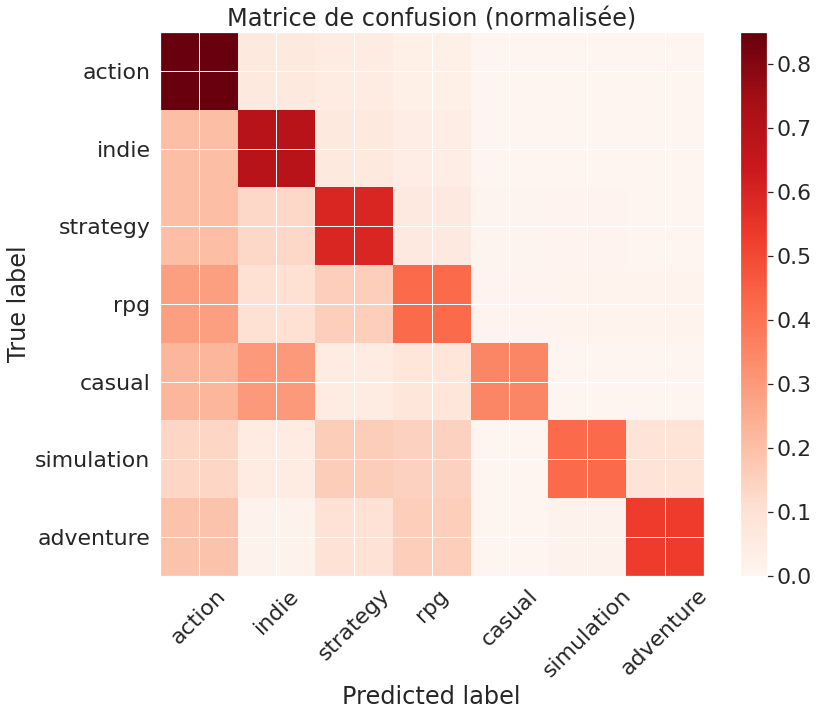

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10))
plot_confusion_matrix(logistic_regression, data_features, y_test, display_labels=genres_choice, include_values=False, xticks_rotation=45, cmap=plt.cm.Reds, normalize='true', ax=ax)
plt.title("Matrice de confusion (normalisée)")

In [ ]:
def words_related_to_genre(vectorizer, genre_index=0, num_words=10): #renvoie les mots qui sont le plus en relation avec le genre d'un jeu
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logistic_regression.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]

In [ ]:
genre_tag_id = 0
print(genreLabels[genre_tag_id])
words_related_to_genre(count_vectorizer, genre_tag_id) #à vérifier si marche vraiment

action


['shooter',
 'monkey',
 'platformer',
 'dash',
 'stage',
 'fight',
 'bullet',
 'freedom',
 'person',
 'shoot']